# Predicting Average Marks Based on Facebook Likes

## Introduction

It is common for students to have a Facebook group on which they post course relevant discussion and announcements to help each other keep up with various aspects. Among the different type of posts, it is customary for people to announce when assessment marks are available to check online, in lieu of a formal notification from the administration. The premise of this short study is that the amount of likes that this sort of post gets can be used to predict the average mark of the assessment.

The reasoning behind this is that students may be less likely to react positively when they check their mark and it turns out to be low, but in case of a high mark, students may feel a need to express their happiness and reward the messenger with a like. Yet, number of likes may be an imperfect measure in many ways:

- Low-ish marks for an exam may excite students if their expectation was low; while good-ish marks for an exam may upset them if they had higher expectations. This indicates there may be a need for a possibly-difficult-to-quantify "expectation" variable. One possible way to address this is by introducing a difficulty variable for each exam based on historical results.
- Number of likes varies depending on the number of students in a class -- this may be addressed by evaluating the percentage of students who liked the post, rather than the raw number.
- People may express their happiness through comments. This may be addressed through counting the number of comments, but also some sorts of sentiment analysis to distinguish between happiness and disappointment. In my experience though, people are much more likely to stick with a simple "like", rather than a more emotional public display of enthusiasm.

This is just a one-day project, so only the 2nd point will be addressed.

### Additional information

This is done for a UK BSc course, so if you are not familiar with the academic environment there, some aspects may not make sense. For example, 70 is considered quite a good mark (first class), and one can pass if they obtain a mark over 30 and they can compensate with marks from a different module. Furthermore, when I talk about "closed assessment" or "closed exam" I refer to an exam typically done with no internet access in about 2 hours, and "open assessment" typically refers to a few week/months-long project (report/experiment/coding/coursework). Also, a bachelor's degree in UK lasts 3 years.

## Collecting data

Due to an unstandardised method of announcing that the marks are up, the collection of the data was accomplished via a tedious process using Facebook group search and manually storing relevant data. I had access to 2 groups, so I gathered data from several academic years and connected every exam to its average mark as released by the university department. I will not make the data public because I'm not sure about the privacy policies involved.

## Exploring data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 12, 10
plt.rcParams.update({'font.size': 15})

In [2]:
data = pd.read_csv('../data/train.csv')

In [3]:
data.describe()

,id,likes,year,cohort,closed,number_of_students,mean,median
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,28.500000,6.750000,2014.500000,2.142857,0.660714,80.571429,61.445536,62.273036
std,16.309506,4.806246,0.603023,0.772918,0.477752,36.801609,9.391542,10.718933
min,1.000000,0.000000,2013.000000,1.000000,0.000000,13.000000,37.040000,31.000000
25%,14.750000,2.750000,2014.000000,2.000000,0.000000,42.000000,55.490000,56.875000
50%,28.500000,6.000000,2015.000000,2.000000,1.000000,80.000000,62.050000,63.250000
75%,42.250000,9.000000,2015.000000,3.000000,1.000000,114.000000,68.417500,70.125000
max,56.000000,19.000000,2015.000000,3.000000,1.000000,131.000000,83.660000,87.000000


As shown above, I managed to collect data for 56 exams. It seems that the minimum mean mark was of 37, and the maximum was of 83.66. On average, it looks like exams tend to end up with a mark slightly above 60 (std of 9.39), about 66% percent have been closed exams, and I collected slightly more data from 3rd years (as seen by the mean of the cohort column.) The minimum number of students that an exam had was 13 (I was there!), and the maximum was 131 (I was there too!).

Anyway, let's get to what is likely the most interesting question right now: is there a distinguishable structure in the data?

Let's plot the number of mean mar against the number of likes.

In [4]:
# Create a quick function to allow reusing
def scatter_plot(independent, dependent, title="", xlabel="", ylabel=""):
    plt.scatter(independent,dependent)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

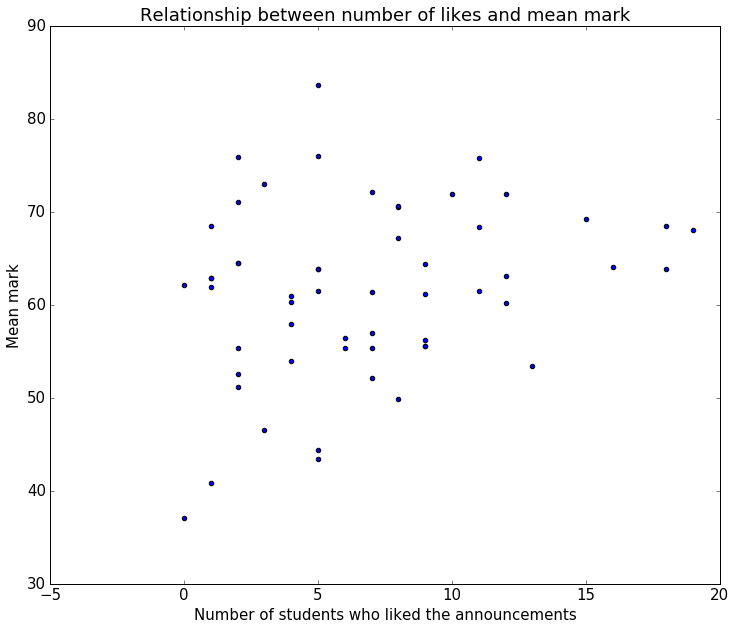

In [5]:
scatter_plot(data['likes'],data['mean'], 
                      title="Relationship between number of likes and mean mark",
                      xlabel="Number of students who liked the announcements",
                      ylabel="Mean mark")

Alright, there is very little structure here, but let's see how it looks when we use the percentage of students.

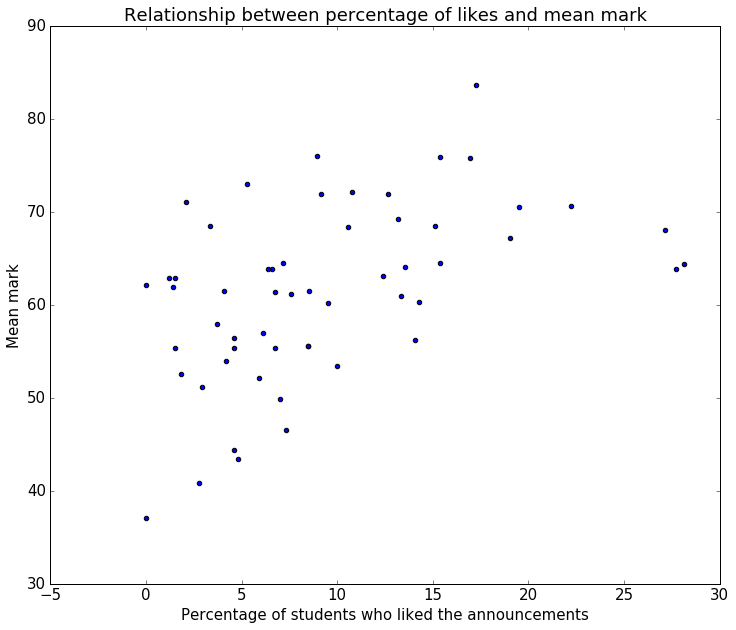

In [6]:
data['likes_normalised'] = (100 * data['likes'])/data['number_of_students']

scatter_plot(data['likes_normalised'],data['mean'], 
                      title="Relationship between percentage of likes and mean mark",
                      xlabel="Percentage of students who liked the announcements",
                      ylabel="Mean mark")

Quite a bit better, but let's do it for the median as it seems like a more intuitive measurement here: half the students below the median got less than the mark indicated on the y axis. Also, the median is more resilient to outliers which may be helpful in this case.

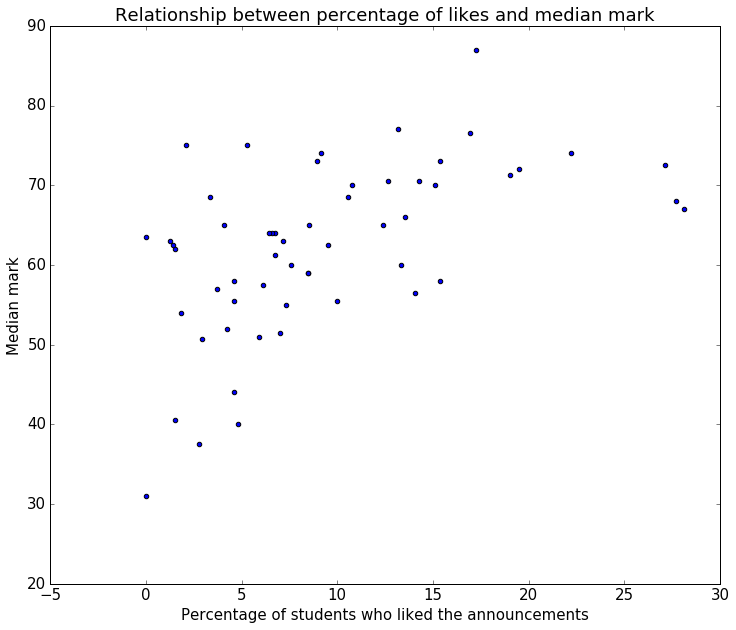

In [7]:
scatter_plot(data['likes_normalised'],data['median'], 
                      title="Relationship between percentage of likes and median mark",
                      xlabel="Percentage of students who liked the announcements",
                      ylabel="Median mark")

Alright, without starting to remove outliers, this seems to be the best I have. I will stay away from outlier detection, and from the graph there doesn't seem to be any really obvious one (maybe besides that one at 80+ median, but I won't go there).

The structure looks like it can be fitted with a polynomial curve, so without further ado, I'll just go ahead and try some polynomial regression.

## Fitting the data

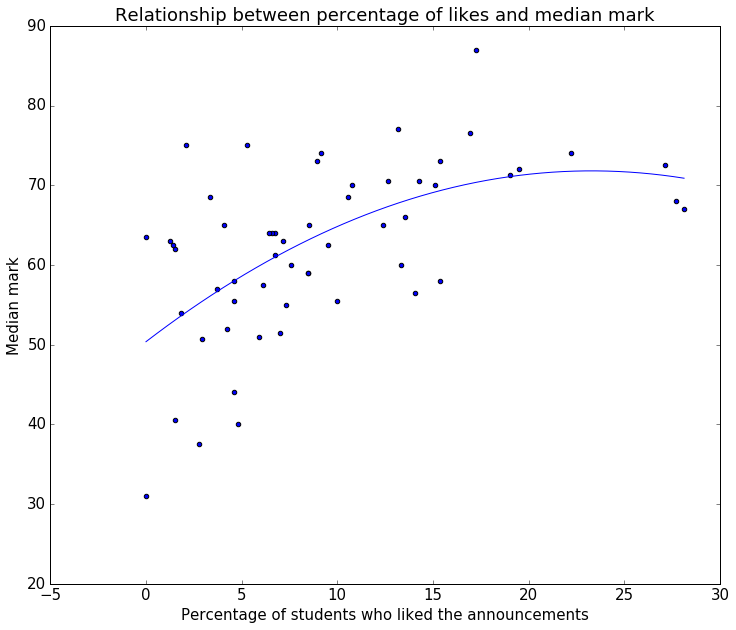

In [8]:
from sklearn import linear_model

# Convert series to dataframes to prepare them for fitting
X = pd.DataFrame(data['likes_normalised'])
y = pd.DataFrame(data['median'])

# Add a squared feature
X = pd.concat([X,pow(X,2)],axis=1)

# Fit data with linear regression
model_linear = linear_model.LinearRegression()
model_linear.fit(X,y)

# Create some new points to graph the curve
new_x = np.linspace(X.iloc[:,0].min(),X.iloc[:,0].max())
test_x = pd.DataFrame([new_x, pow(new_x,2)]).T

# Plot curve
plt.plot(test_x.iloc[:,0],model_linear.predict(test_x))
# Plot points
scatter_plot(X.iloc[:,0],y,
                      title="Relationship between percentage of likes and median mark",
                      xlabel="Percentage of students who liked the announcements",
                      ylabel="Median mark")

Looks about right to me. I don't think stopping here would be a bad decision, but for the sake of it, I will try to fit it with a cubic polynomial.

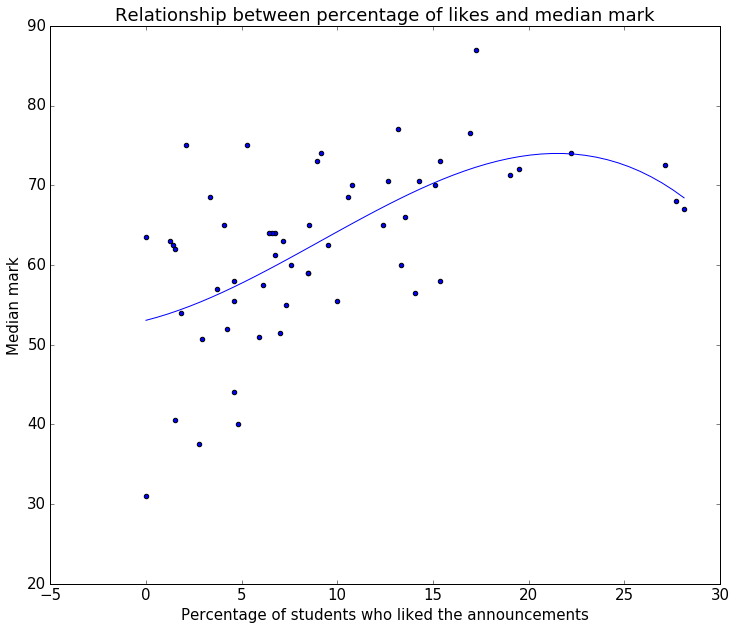

In [9]:
# Add a 3rd power and fit the new data
X_ = pd.concat([X,pow(X.iloc[:,0],3)],axis=1)
model_linear.fit(X_,y)

test_x_ = pd.concat([test_x, pow(test_x.iloc[:,0],3)],axis=1)
plt.plot(test_x_.iloc[:,0],model_linear.predict(test_x_))
# Plot points
scatter_plot(X_[[0]],y,
                      title="Relationship between percentage of likes and median mark",
                      xlabel="Percentage of students who liked the announcements",
                      ylabel="Median mark")

Looks pretty, but it likely overfits. So let's try to add L2 regularization and find the regularization parameter through 10-fold cross validation.

The regularization parameter that provided the best results was 10016.299663688093.


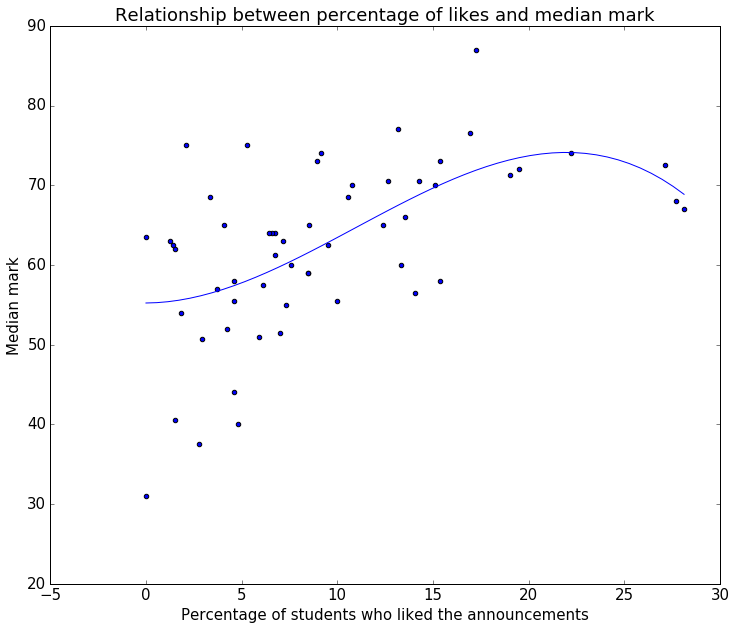

In [10]:
from sklearn.linear_model import RidgeCV

list_reg_params = np.linspace(0.00001, X_.max().max() * 100, 2000)
model_ridge = linear_model.RidgeCV(alphas=list_reg_params, cv=10)
model_ridge.fit(X_,y)

reg_param = model_ridge.alpha_
print("The regularization parameter that provided the best results was {}.".format(reg_param))
plt.plot(test_x_.iloc[:,0],model_ridge.predict(test_x_))
scatter_plot(X_[[0]],y,
                      title="Relationship between percentage of likes and median mark",
                      xlabel="Percentage of students who liked the announcements",
                      ylabel="Median mark")

The regularization parameter introduced only a very subtle difference. It's also a very big number as I haven't normalised the data. Now let's see which of the 2 polynomial curves fit the data better.

## Evaluating the models

In [11]:
model_ridge_reg = linear_model.Ridge(alpha=reg_param)

In [12]:
from sklearn import cross_validation

scores_quadratic = abs(cross_validation.cross_val_score(
        model_linear, X, y, cv=10, scoring="mean_absolute_error"))
scores_cubic = abs(cross_validation.cross_val_score(
        model_ridge_reg, X_, y, cv=10, scoring="mean_absolute_error"))

print("Average error for quadratic polynomial: {:.2f} (+/- {:.2f})" .format(
        scores_quadratic.mean(), scores_quadratic.std() * 2))
print("Average error  for cubic polynomial: {:.2f} (+/- {:.2f})" .format(
        scores_cubic.mean(), scores_cubic.std() * 2))

Average error for quadratic polynomial: 7.05 (+/- 3.87)
Average error  for cubic polynomial: 6.86 (+/- 4.75)


Not too bad. An error of less than 7 marks is better than I expected. Now for a comparison test, let's just predict that the mark of a module is the mean of all the marks (but using K-fold CV).

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import KFold

kf = KFold(X.shape[0], n_folds=10)
scores_naive = []
for train, test in kf:
    train_mean = data['median'][train].mean()
    scores_naive.append(mean_absolute_error(data['median'][test], [train_mean] * len(test)))
    
print("Average error  for naive predictor: {:.2f} (+/- {:.2f})" .format(
        np.mean(scores_naive), np.std(scores_naive) * 2))

Average error  for naive predictor: 8.18 (+/- 6.37)


D'aww, the regression predictor is not much better than the naive one. At least it's not worse! As a last test, let's see what are the chances that the the regression results are better just by chance. For this, a paired one-tailed t-test will be performed, with the null hypothesis that the 2 algorithms perform the same, and the alternative hypothesis that the regression one performs better. The p-value I will choose is 0.05.

In [14]:
from scipy.stats import ttest_rel

results = ttest_rel(scores_naive, scores_cubic)
print("P-value: {:.4f}" .format(results.pvalue/2)) # Dividing by 2 because it's one-tailed

P-value: 0.0387


Everything was not in vain! It seems that the algorithm is likely to perform better than the naive approach.

## Conclusion

And this is it. The algorithm appears to predict grades with an average error of approximately 7 marks, and performs better than a naive predictor. Not bad I'd say considering we only have the number of likes on Facebook!

I did not put aside a separate testing set because the data was not very big to begin with, and I don't think that a small test set would necessarily give a good indication of the algorithm performance. However, I will nonetheless test it on this year's exams once the results and the statistics are up!